# imports:

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact, mannwhitneyu
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold, adjusted_roundup
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk, Load
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

pd.set_option('display.expand_frame_repr', False)


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!
end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'17012019'

# calculate MW test for all features in "top features file"

## top 40 features

In [3]:
featuresFD=pd.read_excel('%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_featureDF_topFeatures.xlsx' %MyPath)

In [4]:
# get samples lists:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530_balancedAge_males') as fp:
    PNP530_balancedAge_males=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126_balancedAge_males') as fp:
    Cardio126_balancedAge_males=pickle.load(fp)

In [5]:
feat_PNP=featuresFD.loc[PNP530_balancedAge_males,:]
print feat_PNP.shape
feat_cardio=featuresFD.loc[Cardio126_balancedAge_males,:]
print feat_cardio.shape

(57, 40)
(93, 40)


In [6]:
MWdf=pd.DataFrame()

for n,col in enumerate(featuresFD.columns):
    pnp_data=feat_PNP[col].dropna().tolist()
    cardio_data=feat_cardio[col].dropna().tolist()
    
    mean_pnp=np.mean(pnp_data)
    mean_cardio=np.mean(cardio_data)
    
    s_MW, p_MW = mannwhitneyu(pnp_data, cardio_data)
    MWdf.loc[col,'mean_pnp']=mean_pnp
    MWdf.loc[col,'mean_cardio']=mean_cardio
    MWdf.loc[col,'s_MW']=s_MW
    MWdf.loc[col,'p_MW']=p_MW
    
nTests = len(MWdf)
FDR = 0.1
MWdf = MWdf.sort_values(by='p_MW')
MWdf = add_corrected_pValues(MWdf, pValueColumn='p_MW', nTests=nTests, FDR=FDR)
MWdf.head()

MWdf.to_excel('%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/feature_comparison_MW_PNP530Cardio126_balancedAge_males.xlsx' %MyPath)

## repeat with top 40 features+annotation features

In [7]:
annotFD=pd.read_excel('%s/TCR_real_data/PNP530Cardio126Combined/annotationFeatures/PNP530Cardio126_PNP530Cardio126_annotationFeatures.xlsx' %MyPath)

In [8]:
feat_annot=pd.merge(featuresFD,annotFD,how='outer',left_index=True,right_index=True)
feat_annot.shape

(656, 124)

In [9]:
feat_annot_PNP=feat_annot.loc[PNP530_balancedAge_males,:]
print feat_annot_PNP.shape
feat_annot_cardio=feat_annot.loc[Cardio126_balancedAge_males,:]
print feat_annot_cardio.shape

(57, 124)
(93, 124)


In [10]:
MWdf2=pd.DataFrame()

for n,col in enumerate(feat_annot.columns):
    pnp_data=feat_annot_PNP[col].dropna().tolist()
    cardio_data=feat_annot_cardio[col].dropna().tolist()
    
    mean_pnp=np.mean(pnp_data)
    mean_cardio=np.mean(cardio_data)
    
    try:
        s_MW, p_MW = mannwhitneyu(pnp_data, cardio_data)
    except:
        print ('couldnt execute MW for col:' ,col)
        s_MW=np.nan; p_MW=np.nan
    MWdf2.loc[col,'mean_pnp']=mean_pnp
    MWdf2.loc[col,'mean_cardio']=mean_cardio
    MWdf2.loc[col,'s_MW']=s_MW
    MWdf2.loc[col,'p_MW']=p_MW

MWdf2=MWdf2[(MWdf2['mean_pnp'].notnull())& (MWdf2['mean_cardio'].notnull())]  
nTests = len(MWdf2)
FDR = 0.1
MWdf2 = MWdf2.sort_values(by='p_MW')
MWdf2 = add_corrected_pValues(MWdf2, pValueColumn='p_MW', nTests=nTests, FDR=FDR)
MWdf2.head()

MWdf2.to_excel('%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/feature_comparison_MW_PNP530Cardio126_balancedAge_males_incAnnot.xlsx' %MyPath)

('couldnt execute MW for col:', u'CalcifiedAorticStenosisdisease_seq_count')
('couldnt execute MW for col:', u'Experimentalautoimmuneencephalomyelitis_seq_count')
('couldnt execute MW for col:', u'GraftVsHostDisease_seq_count')
('couldnt execute MW for col:', u'HSV_seq_count')
('couldnt execute MW for col:', u'Leukemia_seq_count')
('couldnt execute MW for col:', u'Lungcancer_seq_count')
('couldnt execute MW for col:', u'Lymphoma_seq_count')
('couldnt execute MW for col:', u'PbA_seq_count')
('couldnt execute MW for col:', u'Plasmodiumberghei_seq_count')


/usr/wisdom/python/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/wisdom/python/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/wisdom/python/lib/python2.7/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


('couldnt execute MW for col:', u'Tick-borneencephalitis_seq_count')
('couldnt execute MW for col:', u'TriticumAestivum_seq_count')
('couldnt execute MW for col:', u'VSV_seq_count')


/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


# plot selected feature comparison:

generating kde plot
generating kde plot
generating kde plot
generating kde plot
generating kde plot
generating kde plot
generating kde plot
generating kde plot


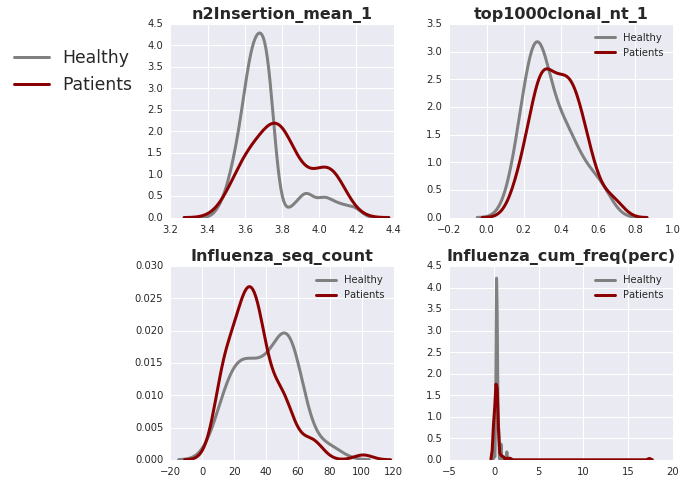

In [13]:
feature_list=['n2Insertion_mean_1','top1000clonal_nt_1','Influenza_seq_count','Influenza_cum_freq(perc)']
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(9,7))


for n,feature in enumerate(feature_list):
    ax=axes.flatten()[n]
    pnp_data=feat_annot_PNP[feature].dropna().tolist()
    cardio_data=feat_annot_cardio[feature].dropna().tolist()
    pnp_data_name='Healthy'
    cardio_data_name='Patients'
    
    dataList=[(pnp_data_name,pnp_data),(cardio_data_name,cardio_data)]
    title=feature
    if n==0: 
        showLegend=True
        handles, labels = ax.get_legend_handles_labels()
        handles
        ax.legend(labels, bbox_to_anchor=(-0.2,0.95))
    else: showLegend=False
        
    ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,
                                title,showLegend=showLegend,nBins=20,toAnnotate=False,alpha=None,plotType='kde',
                                colorList=['grey','darkred'])
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(labels, fontsize='x-large',bbox_to_anchor=(-0.1,0.95))
fig.subplots_adjust(top=0.99,hspace=0.25,wspace=0.25)    
plt.show()
    